# Putatively Useful Code from Ely's Test Notebook, Neurohackweek 2017

- Cloned from the demo introductory_3d.ipynb notebook
- Builds on 
[IPyvolume](https://ipyvolume.readthedocs.io/en/latest/index.html), 
[NiBabel cifti2 package](http://nipy.org/nibabel/reference/nibabel.cifti2.html), 
[Michiel Cottaar's cifti tools](https://git.fmrib.ox.ac.uk/ndcn0236/cifti), and [various NHW demo notebooks](https://github.com/neurohackweek)


In [4]:
# load packages etc
%matplotlib inline
import matplotlib.pyplot as plt

import nibabel as nb
import ipyvolume
import ipyvolume.pylab as p3
import numpy as np
import os
import sys

# be sure to set the global variable NHW to your NHW_visualization git directory
# e.g. add 'export NHW=$HOME/Desktop/nhw2017/NHW_visualization' to your ~/.bashrc file
nhw = os.environ['NHW'] # set the global variable NHW to your NHW_visualization git directory


<b>CIFTI Tools:</b>

In [5]:
def cread(file):
    # loads a cifti file and stores the data and four metadata objects
    # should be called as: cd,ch,cn,cx,cf=cread(input_cifti)
    cin=nb.load(file)
    cdata=np.asarray(cin.get_data()).copy()
    chead=cin.header.copy()
    cnhdr=cin.nifti_header.copy()
    cxtra=cin.extra.copy()
    cfmap=cin.file_map.copy()
    return cdata,chead,cnhdr,cxtra,cfmap

In [6]:
# cread example:
input_cifti=nhw+'/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii'
cd,ch,cn,cx,cf=cread(input_cifti)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [7]:
def clthresh(data,thresh,setto=0):
    # set all values below threshold to a given value (default 0)
    lthr_data=data.copy()
    lthr_data[lthr_data<thresh]=setto
    return lthr_data

In [8]:
def cuthresh(data,thresh,setto=0):
    # set all values above threshold to a given value (default 0)
    uthr_data=data.copy()
    uthr_data[uthr_data>thresh]=setto
    return uthr_data

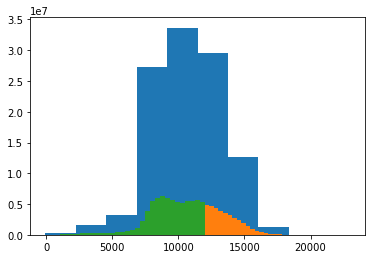

In [19]:
# clthresh/cuthresh example:
tl12000_cd=clthresh(cd,12000)
tu12000_cd=cuthresh(cd,12000)
plt.hist(cd[np.nonzero(cd)], 32);
plt.hist(tl12000_cd[np.nonzero(tl12000_cd)], 32);
plt.hist(tu12000_cd[np.nonzero(tu12000_cd)], 32);

In [12]:
def csave(filename,cdata,chead=None,cnhdr=None,cxtra=None,cfmap=None):
    # saves a cifti data structure to file. Output likely unusable without some header info
    cout=nb.Cifti2Image(dataobj=cdata,header=chead,nifti_header=cnhdr, extra=cxtra, file_map=cfmap)
    cout.to_filename(filename)

In [13]:
# csave example:
output_cifti=nhw+'/save_demo.dtseries.nii'
csave(output_cifti,cd,ch,cn,ch,cf)

In [15]:
def cmask(cdata1,cdata2):
    # masks cifti data 1 with non-zero values of cifti data 2
    # cdata2 can be a single timepoint or matched to cdata1 dimensions
    masked_cdata1=cdata1.copy()
    if cdata1.shape != cdata2.shape:
        mask=np.tile(cdata2,(cdata1.shape[0],1))
    else:
        mask=cdata2.copy()
    masked_cdata1[mask==0]=0
    return masked_cdata1

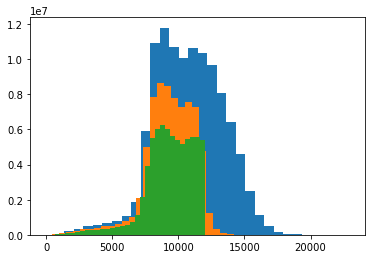

In [16]:
# cmask example:
masked3d=cmask(cd,tu12000_cd[0]) # masking 4d timeseries with single 3d timepoint
masked4d=cmask(cd,tu12000_cd)    # masking 4d timeseries with 4d timeseries
plt.hist(cd[np.nonzero(cd)], 32);
plt.hist(masked3d[np.nonzero(masked3d)], 32);
plt.hist(masked4d[np.nonzero(masked4d)], 32);

In [ ]:
def cplot(coverlay,lsurf,rsurf,subvol,colormap):
    # plots cifti overlay data with specified color on surfaces/subcortex
    # lsurf and rsurf should be .surf.gii files matched to the number of vertices in each cifti hemisphere
    # subvol should be a HCP-style subcortical volume (e.g. Atlas_ROIs.2.nii.gz)
    
    # import packages
    import nibabel as nb
    import matplotlib.pyplot as plt
    import ipyvolume
    import ipyvolume.pylab as p3
    import numpy as np
    
    # read input files
    cd,ch,cn,cx,cf=cread(coverlay) 
    ls=nb.load(lsurf)
    rs=nb.load(rsurf)
    sv=nb.load(subvol)
    
    # parse surface structure
    lxyz=ls.darrays[0]
    rxyz=rs.darrays[0]
    lmesh=ls.darrays[1]
    rmesh=rs.darrays[1]
    
    # parse cifti header
    mim = ch.matrix[1]
    bm1 = list(mim.brain_models)[0]
    bm2 = list(mim.brain_models)[1]
    lidx = list(bm1.vertex_indices)
    ridx = [bm1.surface_number_of_vertices + val for val in bm2.vertex_indices]
    bidx = np.concatenate((lidx, ridx))
    # debug:
    # print(bidx.shape)
    #    for idx, bm in enumerate(mim.brain_models):
    #        print((idx, bm.index_offset, bm.brain_structure))
    
    